In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/kaylahuang/Desktop/GitHub/conflicts/components/")

from views_cleaner import VIEWSCleaner

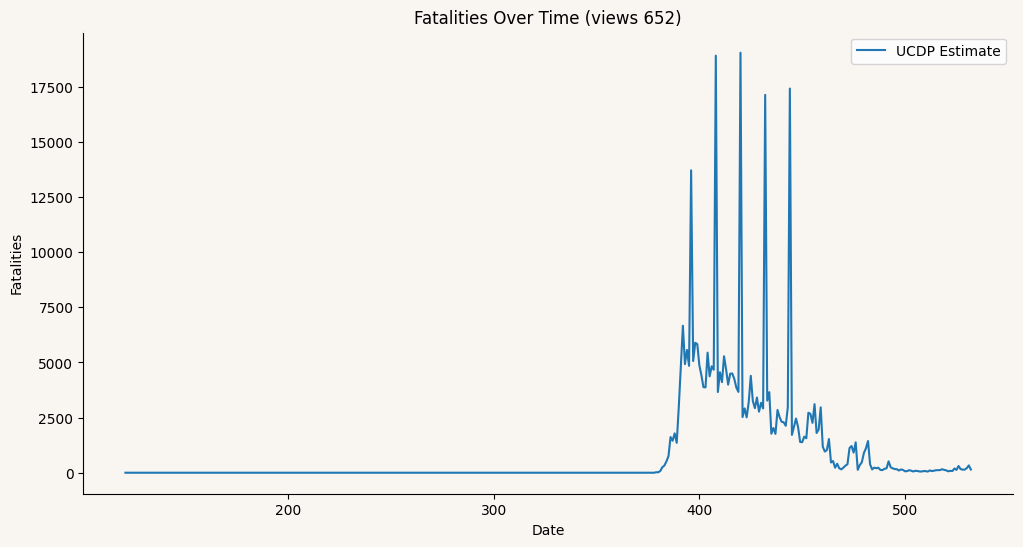

In [38]:
filename = '../data/views23/features/cm/cm_features.parquet'
gw_id = 652 
cleaner = VIEWSCleaner(filename, gw_id)
X = cleaner.features # already aggregated by month
cleaner.plot()


In [39]:
def predict_date(input_month):
    pre_date = X[X['month_id'] <= input_month]
    X_train = pre_date.drop(columns=["ged_sb"])
    y_train = pre_date["ged_sb"]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # prediction
    row = X[X['month_id'] == input_month]
    prediction = model.predict(row.drop(columns=["ged_sb"]))
    return prediction[0], row["ged_sb"].values[0], model.feature_importances_
    

In [43]:
month = 450
WIDTH = 5

importances_list = [] 

for m in range(month, month+WIDTH):
    p, true, feature_imp = predict_date(m)
    print("prediction: ", p)
    print("true: ", true)
    importances_list.append(feature_imp)



prediction:  1483.98
true:  1385
prediction:  1577.61
true:  1634
prediction:  1562.52
true:  1561
prediction:  2286.0
true:  2718
prediction:  2537.72
true:  2668


In [42]:
# # plotting feature importance for one model 
# importances = feature_imp
# feature_names = X.drop(columns=["ged_sb"]).columns

# # Get the threshold for the top 25% important features
# threshold = np.percentile(importances, 75)
# filtered_importances = importances[importances >= threshold]
# filtered_feature_names = feature_names[importances >= threshold]

# plt.figure(figsize=(10, 6))
# plt.barh(filtered_feature_names, filtered_importances)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature Names')
# plt.title('Top 25% Feature Importances')
# plt.show()

['month_id', 'vdem_v2xnp_client', 'renewable_pcap_t48', 'renewable_internal_pcap_t48', 'services_efficiency_t48', 'general_efficiency_t48', 'wdi_nv_agr_totl_kn', 'wdi_sm_pop_netm', 'splag_vdem_v2xcl_rol', 'splag_vdem_v2xpe_exlsocgr']


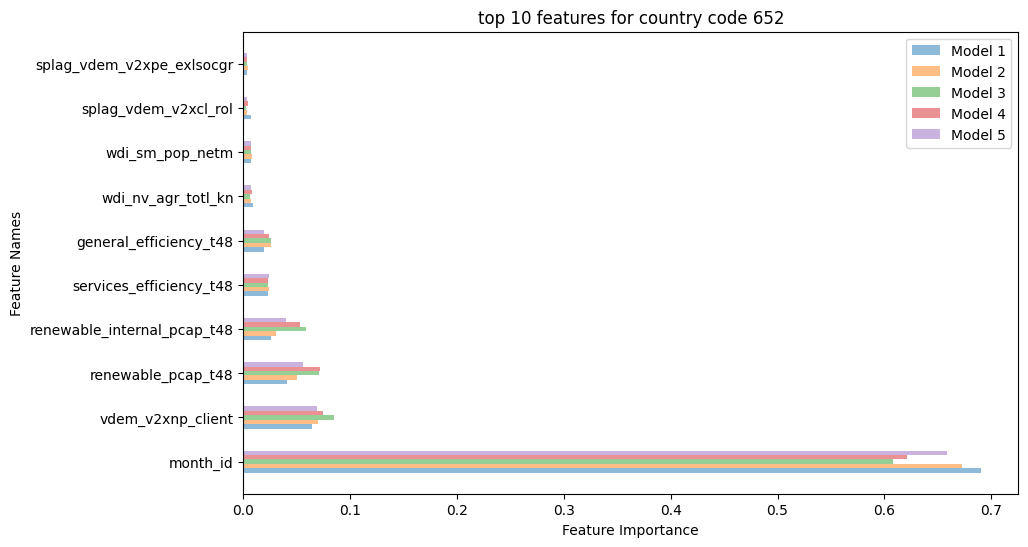

In [44]:
TOP_N = 10
feature_names = X.drop(columns=["ged_sb"]).columns

# Create a DataFrame to store feature importances from all models
importance_df = pd.DataFrame(importances_list, columns=feature_names)

# Calculate the mean importance for each feature across all models
mean_importances = importance_df.mean(axis=0)

# Get the top 5 features based on mean importance
top_features = mean_importances.nlargest(TOP_N).index

print(list(top_features))
top_importances = importance_df[top_features]

plt.figure(figsize=(10, 6))
bar_width = 0.1

# positions for the bars
positions = np.arange(len(top_features))

# model's feature importances next to each other
for i, importances in enumerate(importances_list):
    plt.barh(positions + i * bar_width, top_importances.iloc[i], bar_width, alpha=0.5, label=f'Model {i+1}')

# y ticks in the middle of the grouped bars
plt.yticks(positions + bar_width * (len(importances_list) - 1) / 2, top_features)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title(f'top {TOP_N} features for country code {gw_id}')
plt.legend()
plt.show()


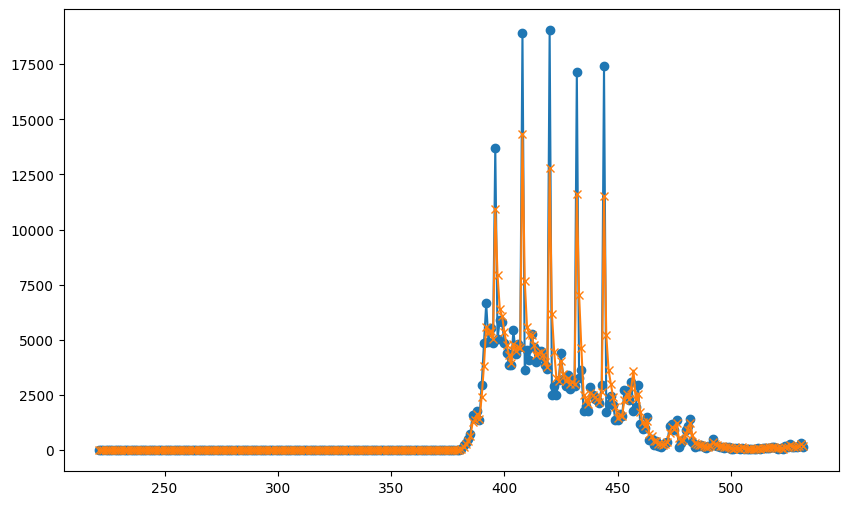

In [45]:
dates_to_predict = X['month_id'].values[100:]

ground_truth = []
predictions = []

for date in dates_to_predict:
    p, t, feature_imp = predict_date(date)
    ground_truth.append(t)
    predictions.append(p)

plt.figure(figsize=(10, 6))

plt.plot(dates_to_predict, ground_truth, label='Actual', marker='o')
plt.plot(dates_to_predict, predictions, label='Predicted', marker='x')


In [46]:
mse = mean_squared_error(ground_truth, predictions)
print(mse) # 7051.357089690721 for sri lanka 

696837.038186859


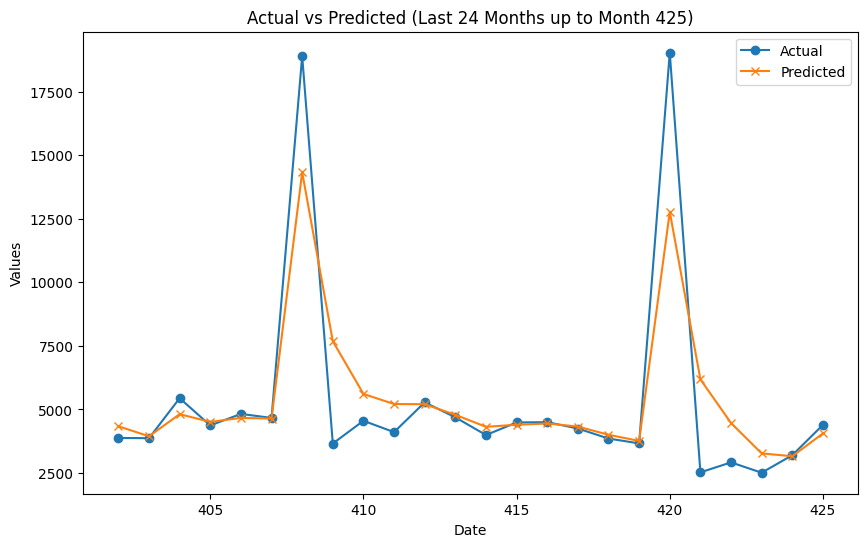

In [49]:
# Define the window size
window_size = 24

# function to plot the last 'window_size' data points from a given month
def plot_last_window_from_month(month, window_size):
    if month in dates_to_predict:
        month_index = list(dates_to_predict).index(month)
        
        # Ensure there are enough data points
        if month_index + 1 >= window_size:
            # Select the last 'window_size' data points up to the given month
            window_dates = dates_to_predict[month_index + 1 - window_size:month_index + 1]
            window_ground_truth = ground_truth[month_index + 1 - window_size:month_index + 1]
            window_predictions = predictions[month_index + 1 - window_size:month_index + 1]

            # Plot the smaller subset
            plt.figure(figsize=(10, 6))
            plt.plot(window_dates, window_ground_truth, label='Actual', marker='o')
            plt.plot(window_dates, window_predictions, label='Predicted', marker='x')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.title(f'Actual vs Predicted (Last {window_size} Months up to Month {month})')
            plt.legend()
            plt.show()
        else:
            print(f"Not enough data points to create a window of {window_size} months up to month {month}.")
    else:
        print(f"Month {month} is not in the dates to predict.")

# Example usage
plot_last_window_from_month(425, window_size)
